# Room Classification

### Python libraries

In [51]:
import numpy as np
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.models import Model
from keras.layers import Input
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping



### Constants

In [52]:
MODEL_INPUT_WIDTH = 48
MODEL_INPUT_HEIGHT = 48
TFL_MODEL_FILE = "room_classification.tflite"
TFL_MODEL_HEADER_FILE = "room_classification.h"
TF_MODEL = "room_classification"

### This is the Room Classification Training data set

In [53]:
data_dir = "bedroom_class_lift_train"

### Prepare the train (80%) and validation (20%) datasets. Batch Size = 32  (Default value)

In [54]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

Found 156 files belonging to 3 classes.
Using 125 files for training.
Found 156 files belonging to 3 classes.
Using 31 files for validation.


### Get the name of the classes

In [55]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['bedroom', 'class', 'lift']


### Rescale the pixel values from [0, 255] tp [-1, 1]

In [56]:
rescale = tf.keras.layers.Rescaling(1./255, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

### Augment the input data

In [57]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Model

In [58]:




model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])






### Compile the model with a 0.0005 learning rate

In [59]:
lr = 0.0005
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Model summary

In [60]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                

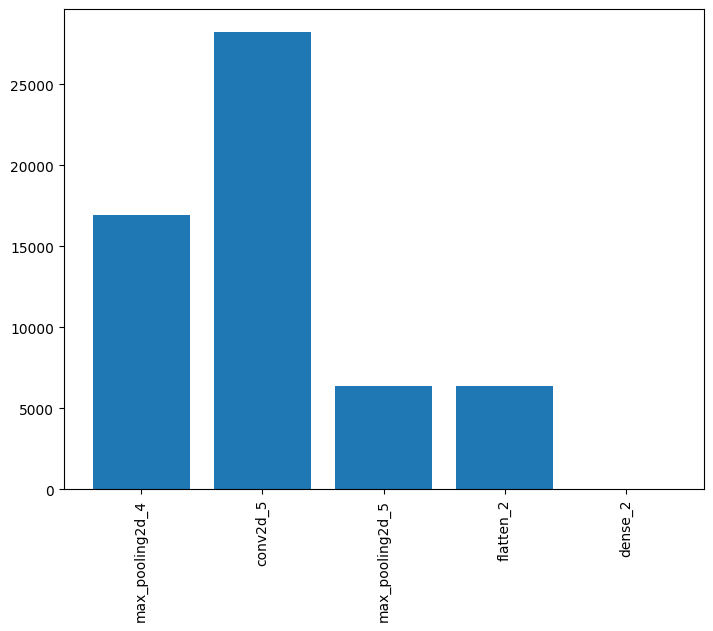

57955.0


In [61]:


fig = plt.figure(dpi=100)
ax = fig.add_axes([0,0,1,1])

l_idx   = []
l_sizes = []

for layer in model.layers[1:]:
  shape = layer.output_shape
  shape = np.delete(shape, 0)
  size  = np.prod(shape)
  l_idx   = np.append(l_idx, layer.name)
  l_sizes = np.append(l_sizes, size)

ax.bar(l_idx, l_sizes)
plt.xticks(rotation='vertical')
plt.show()

print(l_sizes.sum())

### Train the model with 100 epochs

In [62]:
total_samples = 39 + 85 + 50
class_weights = {
    0: total_samples / 39,  # bedroom
    1: total_samples / 85,  # classrooms
    2: total_samples / 50,  # lift
}

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)


model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stopping]  # Pass early stopping callback
)


Epoch 1/100


2024-05-01 23:29:40.716036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [125]
	 [[{{node Placeholder/_0}}]]
2024-05-01 23:29:40.716363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [125]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - ETA: 0s - loss: 3.2938 - accuracy: 0.5120

2024-05-01 23:29:41.553665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype resource
	 [[{{node Placeholder/_19}}]]
2024-05-01 23:29:41.554354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype resource
	 [[{{node Placeholder/_19}}]]


4/4 [==============================] - 1s 184ms/step - loss: 3.2938 - accuracy: 0.5120 - val_loss: 1.0861 - val_accuracy: 0.6129
Epoch 2/100
4/4 [==============================] - 0s 92ms/step - loss: 3.2062 - accuracy: 0.4640 - val_loss: 1.0596 - val_accuracy: 0.6129
Epoch 3/100
4/4 [==============================] - 0s 67ms/step - loss: 3.1681 - accuracy: 0.5280 - val_loss: 1.0384 - val_accuracy: 0.7097
Epoch 4/100
4/4 [==============================] - 0s 78ms/step - loss: 3.1787 - accuracy: 0.5280 - val_loss: 1.0145 - val_accuracy: 0.6129
Epoch 5/100
4/4 [==============================] - 0s 82ms/step - loss: 3.1489 - accuracy: 0.5280 - val_loss: 1.0017 - val_accuracy: 0.6129
Epoch 6/100
4/4 [==============================] - 0s 92ms/step - loss: 3.1193 - accuracy: 0.5280 - val_loss: 1.0122 - val_accuracy: 0.6129
Epoch 7/100
4/4 [==============================] - 0s 89ms/step - loss: 3.1142 - accuracy: 0.5280 - val_loss: 1.0228 - val_accuracy: 0.6129
Epoch 8/100
4/4 [==============

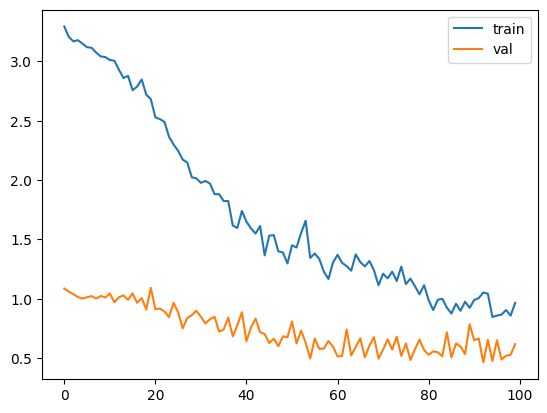

In [63]:
# plot training error and validation error over epochs
import matplotlib.pyplot as plt
history = model.history.history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.show()



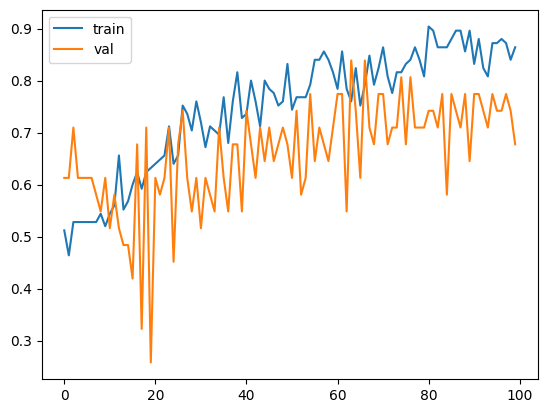

In [64]:
# plot training accuracy and validation accuracy over epochs
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.show()


### Save the TensorFlow model

In [65]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: room_classification/assets


INFO:tensorflow:Assets written to: room_classification/assets


### Getting Metrix of the model

In [66]:
import model_profiler
from model_profiler import model_profiler

Batch_size = 32
profile = model_profiler(model, Batch_size,use_units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB'])
print(profile)


| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.1995        | MFLOPs  |
| GPU Memory Requirement           | 15.377        | MB      |
| Model Parameters                 | 0.0386        | Million |
| Memory Required by Model Weights | 0.1472        | MB      |


2024-05-01 23:30:28.998842: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Read test dataset 

In [67]:
test_dir = "bedroom_class_lift_test"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [68]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 26 files belonging to 3 classes.


### Calculating the Accuracy of Model(Uncompressed) on the Test set

In [69]:
# evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2024-05-01 23:30:29.093016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{node Placeholder/_4}}]]
2024-05-01 23:30:29.093754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 71ms/step - loss: 0.2914 - accuracy: 0.9231
Accuracy 0.9230769276618958


### Show predictions

1/1 [==============================] - 0s 48ms/step


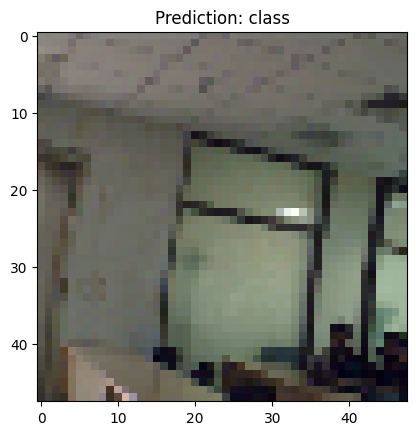

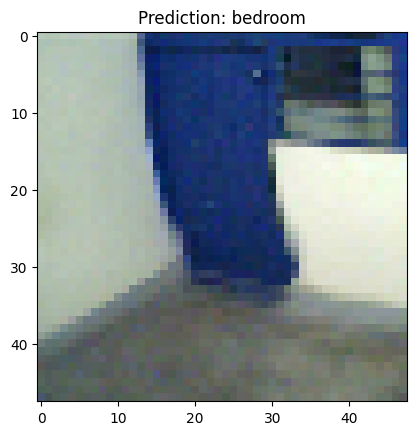

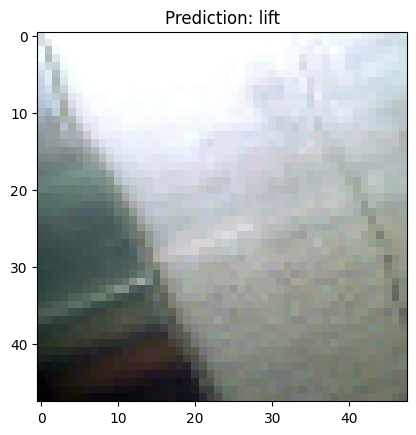

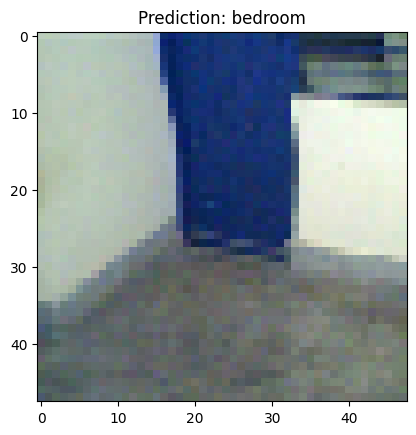

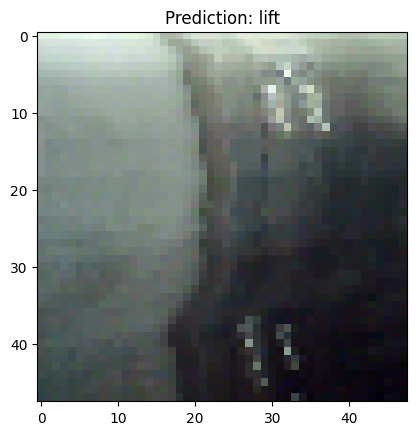

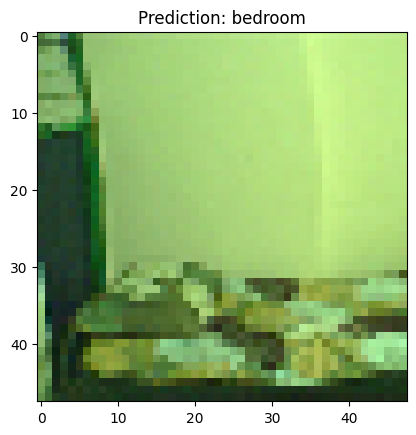

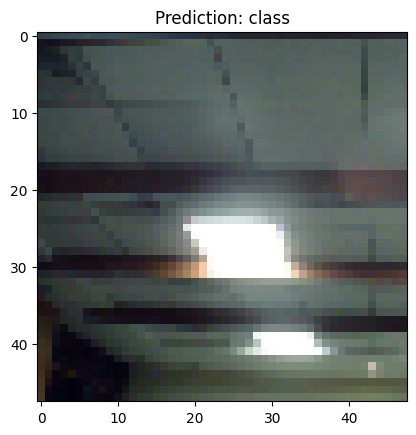

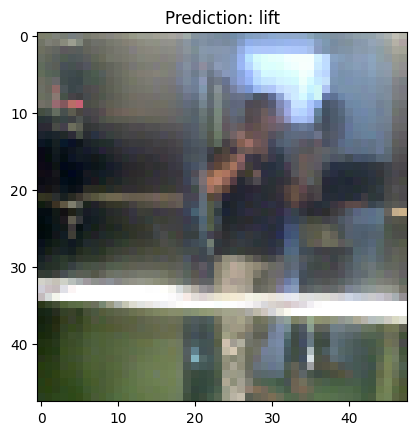

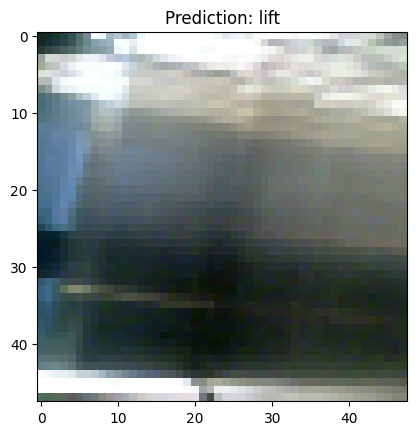

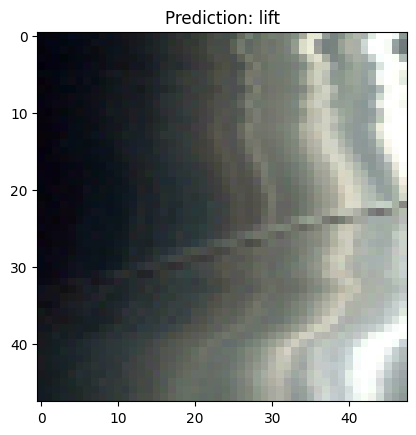

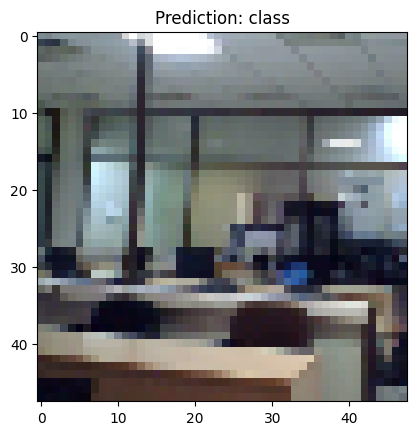

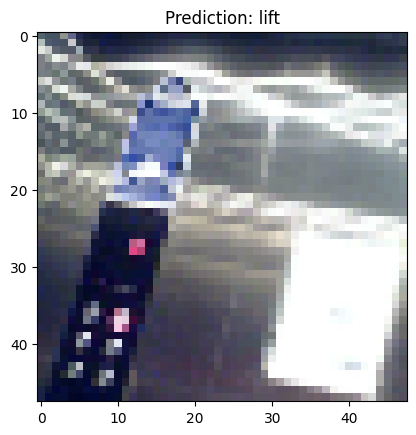

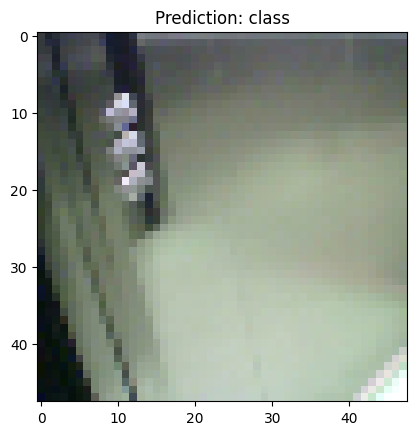

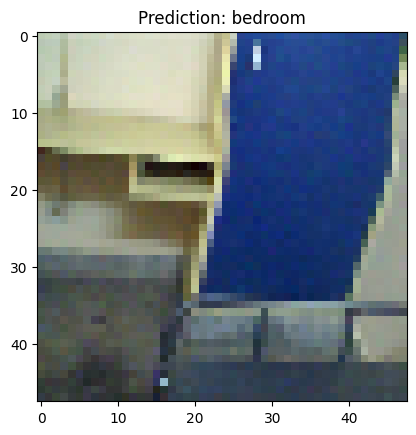

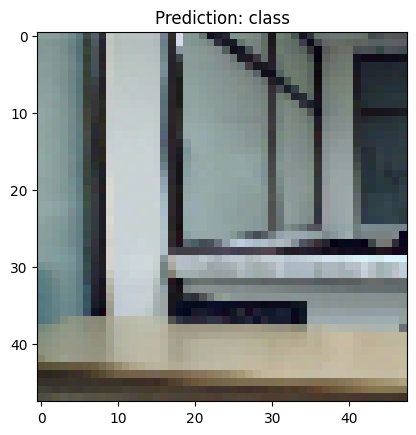

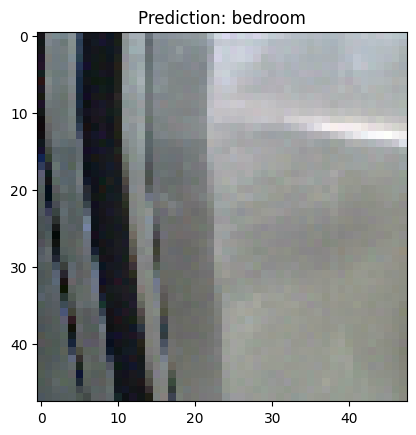

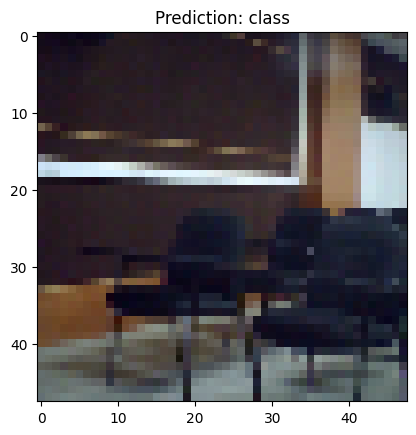

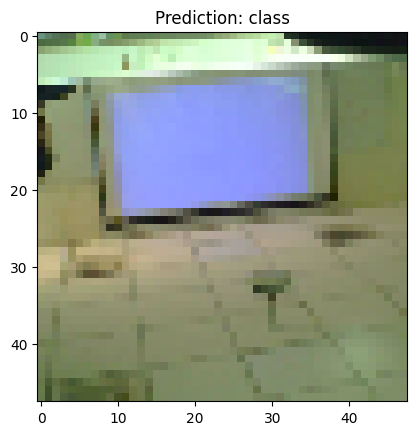

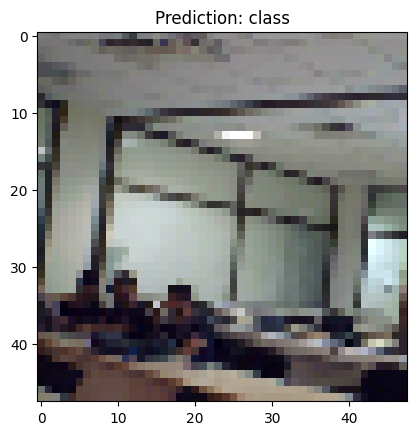

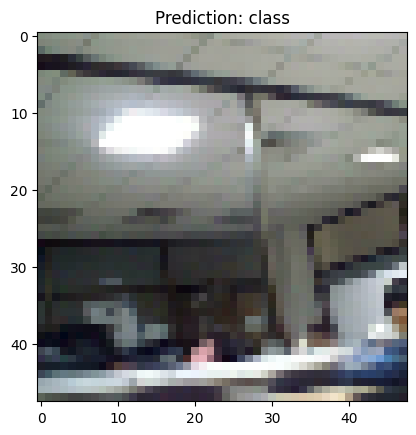

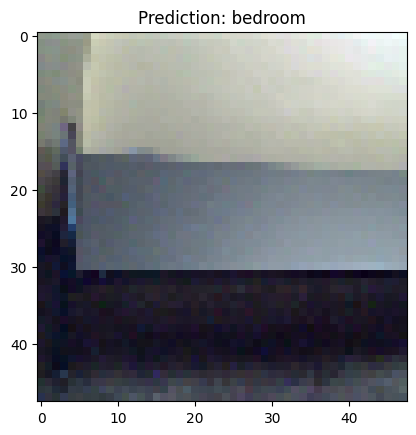

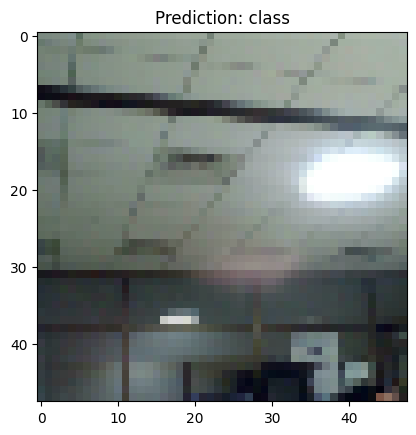

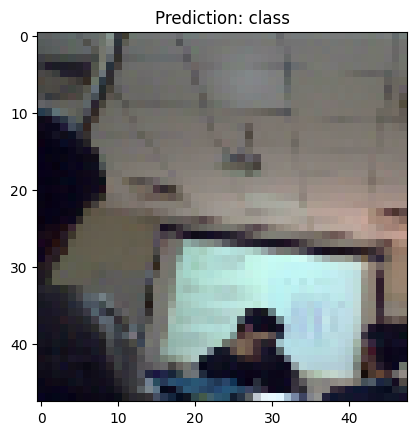

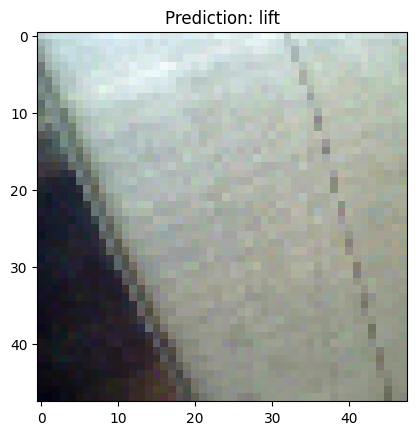

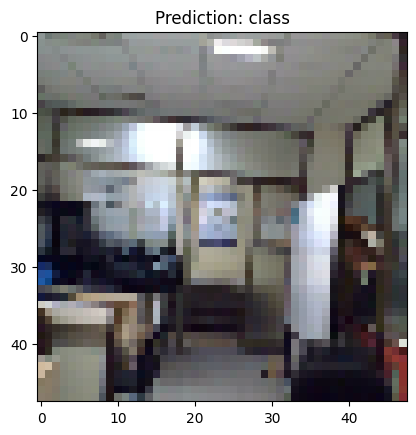

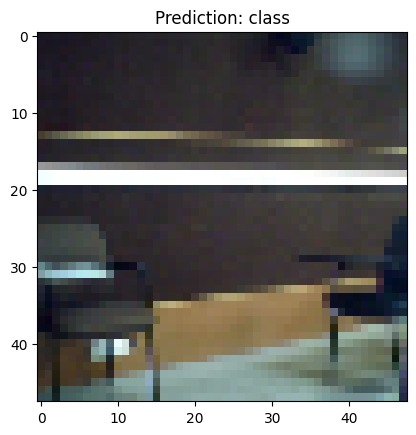

In [70]:
# Show image and prediction for all images in the test set
for image, label in test_ds:
    predictions = model.predict(image)
    for i in range(len(image)):
        # Normalize the image to [0..1] range
        img = image[i].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        plt.title(f"Prediction: {class_names[np.argmax(predictions[i])]}")
        plt.show()
    break



## Convert the TensorFlow model to TensorFlow Lite


In [71]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
tflite_model = converter.convert()

2024-05-01 23:30:31.869309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-01 23:30:31.869346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-01 23:30:31.869508: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: room_classification
2024-05-01 23:30:31.870664: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-01 23:30:31.870680: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: room_classification
2024-05-01 23:30:31.873910: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-01 23:30:31.905336: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: room_classification
2024-05-01 23:30:31.931467: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Too

In [72]:
# print size of the tflite model
print(f"Size of the tflite model without quantization: {len(tflite_model)} bytes")

Size of the tflite model without quantization: 157444 bytes


## Preparing and testing the quantized TFLite model

### Quantize the TensorFlow model with the TFLite converter

In [73]:
repr_ds = val_ds.unbatch()

# Selecting few samples randomply from the validation dataset to calibrate the quantization
def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]

# Import the TF Saved model directory into TFLite converter
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

# Representative dataset
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)

# Optimizatoins
# DEFAULT: Optimize for both size and latency, minimizing the accuracy drop
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Supported ops
# Forces the adoption of only integer 8-bit operators during conversion.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Inference input type
# This adopts the 8-bit quantization format for network inputs
# Therefore we will need to input quantized input features
converter.inference_input_type = tf.int8

tfl_model = converter.convert()

2024-05-01 23:30:32.244702: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-01 23:30:32.244727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-01 23:30:32.244879: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: room_classification
2024-05-01 23:30:32.246010: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-01 23:30:32.246025: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: room_classification
2024-05-01 23:30:32.249169: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-01 23:30:32.280094: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: room_classification
2024-05-01 23:30:32.287914: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Too

### Get the TFLite model size in bytes

In [74]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

44888 bytes


### Initialize the TFLite interpreter

In [75]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

### Get input quantization parameters

In [76]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]

### Evaluate the accuracy of the quantized TFLite model

In [77]:
test_ds0 = test_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))


for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]
  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

print("Accuracy:", num_correct_samples/num_total_samples)


2024-05-01 23:30:32.647238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{node Placeholder/_4}}]]
2024-05-01 23:30:32.648207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [26]
	 [[{{node Placeholder/_0}}]]
2024-05-01 23:30:32.713427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{

Accuracy: 0.9230769230769231


2024-05-01 23:30:32.837870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{node Placeholder/_4}}]]
2024-05-01 23:30:32.838423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [26]
	 [[{{node Placeholder/_4}}]]


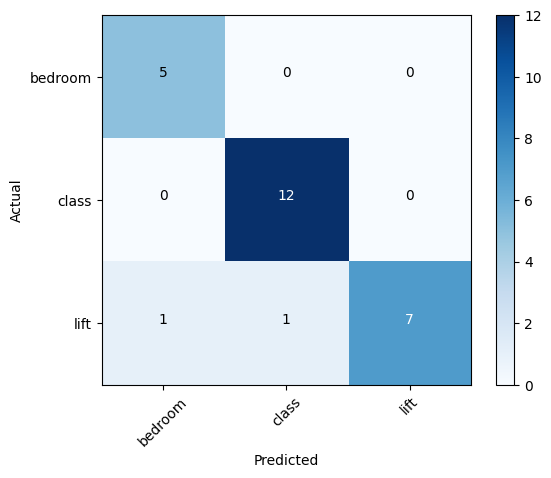

[[ 5  0  0]
 [ 0 12  0]
 [ 1  1  7]]


In [78]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

test_ds0 = test_ds.unbatch()
y_true = []
y_pred = []

for i_value, o_value in test_ds0.batch(1):
    i_value = (i_value / i_scale) + i_zero_point
    i_value = tf.cast(i_value, dtype=tf.int8)
    interpreter.set_tensor(i_details["index"], i_value)
    interpreter.invoke()
    o_pred = interpreter.get_tensor(o_details["index"])[0]
    y_true.append(o_value.numpy()[0])
    y_pred.append(np.argmax(o_pred))

cm = confusion_matrix(y_true, y_pred)



# show numerical values in the cells
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()

# show numerical values in the cells
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.show()

# print the confusion matrix
print(cm)



## Generating header file for the TensorFlow Lite model

In [79]:
open("model.tflite", "wb").write(tfl_model)
!xxd -c 60 -i model.tflite > room_classification.h